In [1]:
# Create a Simulate Environment

# Imports

In [250]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import os



%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from environment import LinearArray
from audio_datasets import YesNoDataset
from beamformer import DasBeamformer,MvdrBeamformer

## Linear Array

In [251]:
M = 5
L = 20000
d = 0.05
fs = 16000
lin_arr = LinearArray(M,L,d,fs)
print(lin_arr.__len__())

0


In [252]:
# Load signal

s1 = 1*torch.sin(2*np.pi *500* 1/fs*torch.arange(0,L))
s2 = 1*torch.sin(2*np.pi *600* 1/fs*torch.arange(0,L))

sources = [s1,s2]
thetas = [30,60]

for i in range(len(sources)):
  lin_arr.add_signal(sources[i],theta=thetas[i])

target_i = 0

torch.Size([20000]) torch.Size([257, 79])
torch.Size([20000]) torch.Size([257, 79])


torch.Size([2, 5, 257])


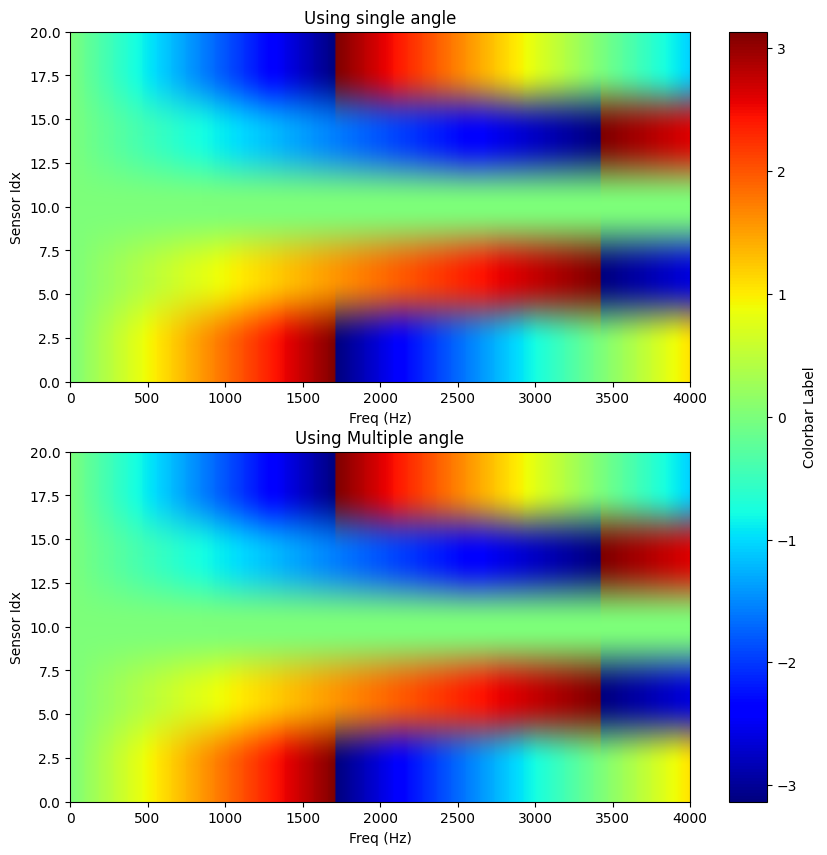

In [253]:
# Test S_Vec
s_vec = lin_arr.eval_svec(thetas[0])

# Test Multiple angles s_vec and index for 30 deg
s_vec_multi = lin_arr.eval_svec_multiangle(thetas)
print(s_vec_multi.shape)

# Plot if there is any discrepancy
f,ax = plt.subplots(2,1,figsize=(10,10))
im = ax[0].imshow(torch.angle(s_vec),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[0].set_title('Using single angle')
ax[1].imshow(torch.angle(s_vec_multi[0,:,:]),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[1].set_title('Using Multiple angle')
for i in range(len(ax)):
  ax[i].set_xlabel('Freq (Hz)')
  ax[i].set_ylabel('Sensor Idx')

# Add colorbar
cbar = f.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

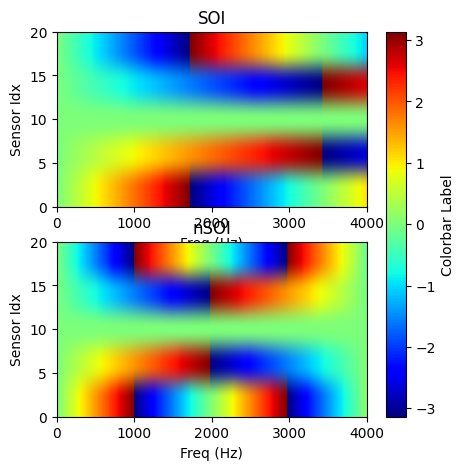

In [254]:
# Compare different angle of incidence
# Test S_Vec
s_vec1 = lin_arr.eval_svec(thetas[0])
s_vec2 = lin_arr.eval_svec(thetas[1])

# Plot if there is any discrepancy
f,ax = plt.subplots(2,1,figsize=(5,5))
im = ax[0].imshow(torch.angle(s_vec1),aspect='auto',extent=(0,4000,0,20),cmap='jet')
im = ax[1].imshow(torch.angle(s_vec2),aspect='auto',extent=(0,4000,0,20),cmap='jet')
ax[0].set_title('SOI')
ax[1].set_title('nSOI')
for i in range(len(ax)):
  ax[i].set_xlabel('Freq (Hz)')
  ax[i].set_ylabel('Sensor Idx')

# Add colorbar
cbar = f.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

In [255]:
# Sensor Reading Test
sensor_output = lin_arr.read_sensor()

print(sensor_output.shape) # M, L'

[30, 60]
torch.Size([2, 257, 79]) torch.Size([2, 5, 257])
torch.Size([5, 19968])


[60]
torch.Size([1, 257, 79]) torch.Size([1, 5, 257])


(0.0, 100.0)

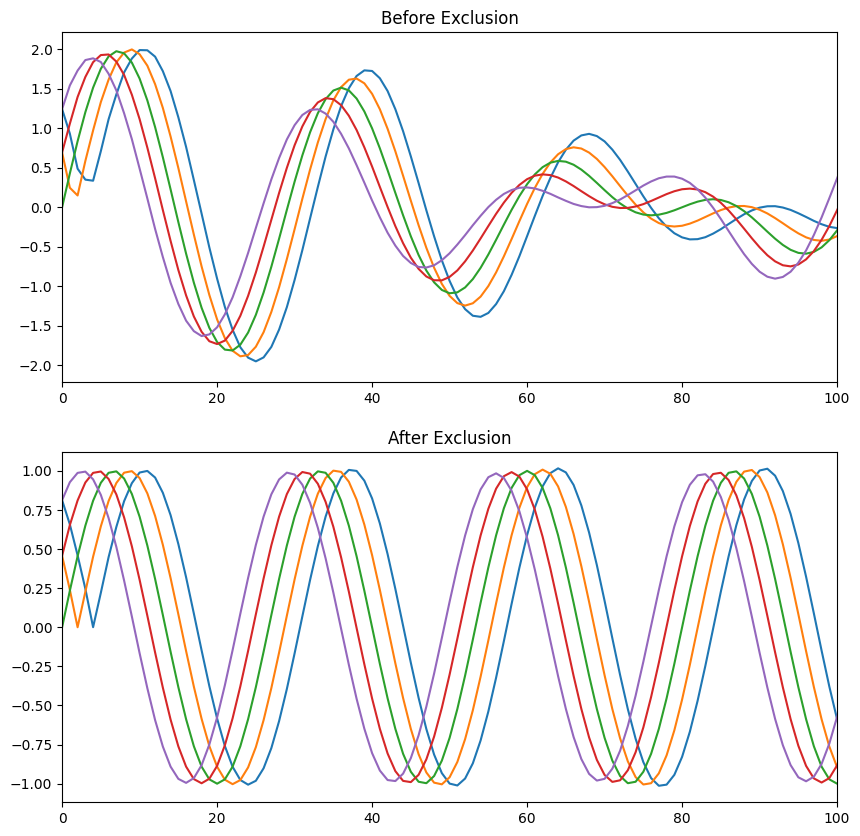

In [256]:
# Sensor Reading with Exclusion
sensor_output_minus = lin_arr.read_sensor(theta_exclude=thetas[target_i])

# plot the multi sensor data
fig,ax = plt.subplots(2,1,figsize=(10,10))

for m in range(M):
  x = sensor_output[m,:]
  ax[0].plot(x)

for m in range(M):
  x = sensor_output_minus[m,:]
  ax[1].plot(x)
ax[0].set_title('Before Exclusion')
ax[1].set_title('After Exclusion')
ax[0].set_xlim([0,100])
ax[1].set_xlim([0,100])

In [257]:
# Test DAS Beamformer
beamformer = DasBeamformer(lin_arr)

# DAS weight
w = beamformer.eval_weight(thetas[target_i])

# Apply the weight
Y = beamformer.apply_beamformer(thetas[target_i])


[30, 60]
torch.Size([2, 257, 79]) torch.Size([2, 5, 257])


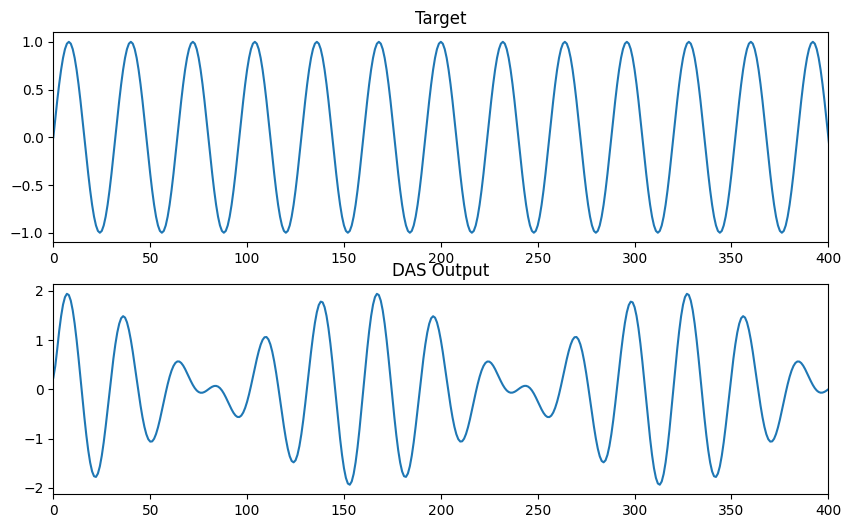

In [258]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
ax[1].plot(Y)
ax[1].set_title('DAS Output')

ax[0].plot(sources[target_i])
ax[0].set_title('Target')

for i in range(len(ax)):
  ax[i].set_xlim([0,400])

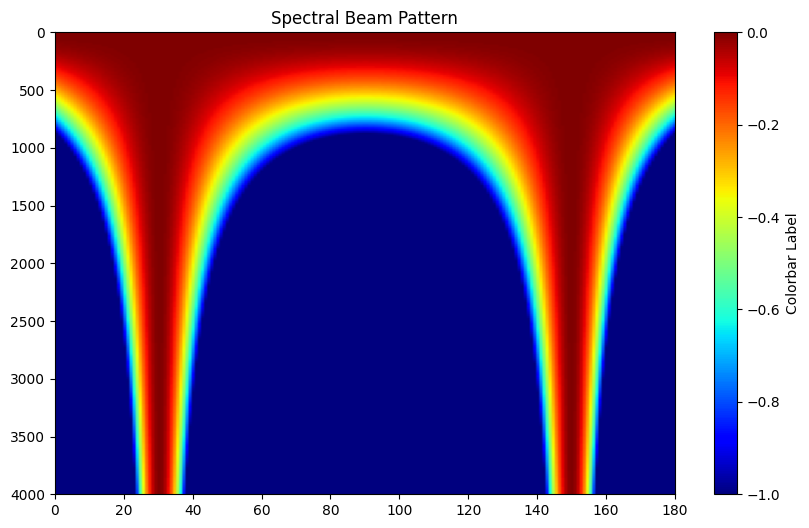

In [221]:
# Plot beam pattern
bp = beamformer.beam_pattern(target_theta=thetas[target_i],Ntheta=200)

fig,ax = plt.subplots(figsize=(10,6))
im = ax.imshow(bp,cmap='jet',aspect='auto',extent=[0,180,fs/2,0], clim=(-1,0))
ax.set_title('Spectral Beam Pattern')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

## MVDR

[30, 60]
torch.Size([2, 257, 196]) torch.Size([2, 11, 257])
torch.Size([257, 200])


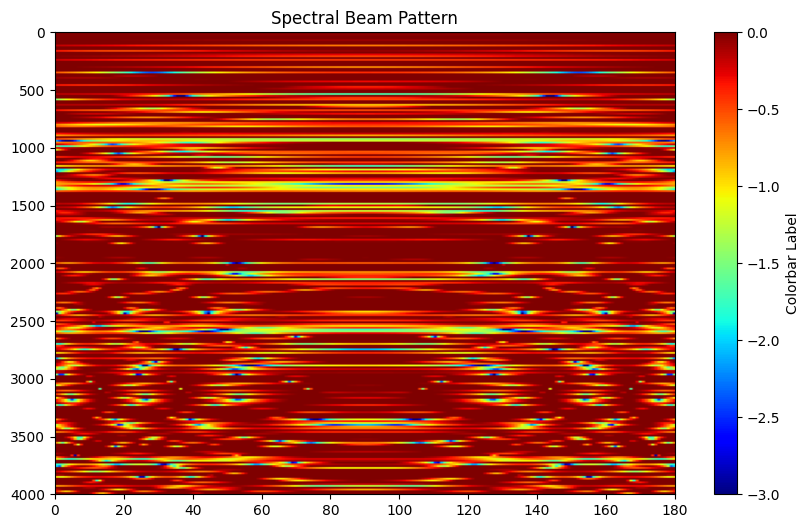

In [222]:
# Evaluate Beam pattern
# Plot beam pattern
beamformer = MvdrBeamformer(lin_arr)
bp = beamformer.beam_pattern(target_theta=thetas[target_i],Ntheta=200)
print(bp.shape)

fig,ax = plt.subplots(figsize=(10,6))
im = ax.imshow(bp,cmap='jet',aspect='auto',extent=[0,180,fs/2,0], clim=(-3,0))
ax.set_title('Spectral Beam Pattern')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Colorbar Label")  # Optional: Set a label for the colorbar

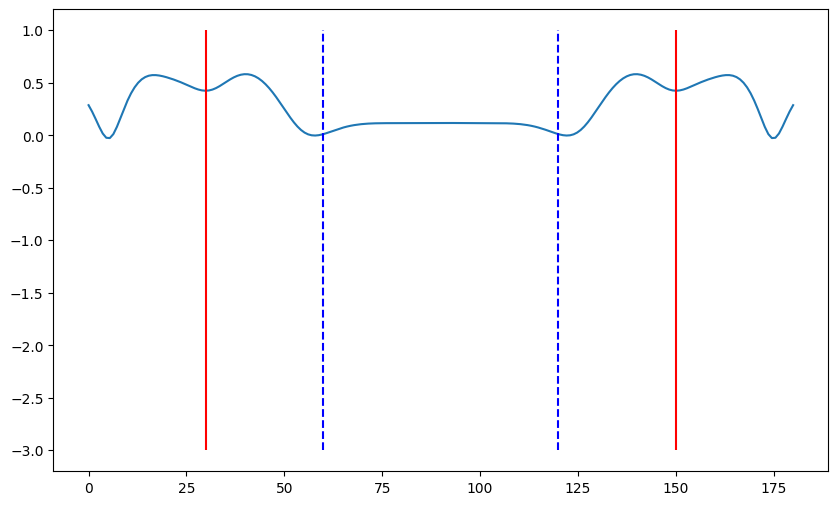

In [205]:
# Get a slice
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(torch.linspace(0,180,bp.shape[-1]),bp[125,:])
ax.vlines([thetas[target_i],180-thetas[target_i]],ymin=-3,ymax=1,colors='r')
ax.vlines([thetas[-1],180-thetas[-1]],ymin=-3,ymax=1,colors='b',linestyles='--')

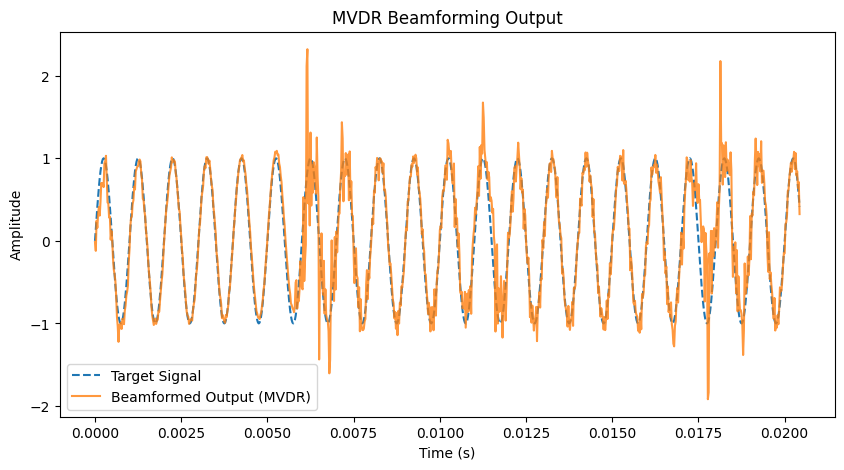

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchaudio

# Simulation Parameters
c = 343.0  # Speed of sound in m/s
fs = 44000  # Sampling frequency (Hz)
d = 0.01  # Distance between microphones (m)
M = 14  # Number of microphones
T = 2.0  # Duration of signal (s)
n_samples = int(fs * T)
t = torch.arange(n_samples) / fs  # Time axis

# STFT parameters
n_fft = 512
hop_length = 256
freqs = torch.fft.rfftfreq(n_fft, d=1/fs)  # Frequency bins

# Source Signals
freq_target = 1000  # Target signal frequency (Hz)
freq_interf = 400  # Interference frequency (Hz)

target_signal = torch.sin(2 * torch.pi * freq_target * t)
interf_signal = torch.sin(2 * torch.pi * freq_interf * t)

# Angles of arrival (AoA)
theta_target = -60  # Target source angle (degrees)
theta_interf = 80 # Interfering source angle (degrees)

def compute_delays(theta, M, d, c):
    """Compute time delays for a given angle."""
    theta_rad = torch.deg2rad(torch.tensor(theta))
    delays = torch.arange(M) * d * torch.sin(theta_rad) / c  # Delay per mic
    return delays

# Compute delays
delays_target = compute_delays(theta_target, M, d, c)
delays_interf = compute_delays(theta_interf, M, d, c)

# Create multi-microphone signals
mics = torch.zeros((M, n_samples))
int_mics = torch.zeros((M, n_samples))
for m in range(M):
    shift_t = int(delays_target[m] * fs)
    shift_i = int(delays_interf[m] * fs)
    
    # Apply delays using roll (circular shift)
    mics[m] += torch.roll(target_signal, shift_t)
    mics[m] += torch.roll(interf_signal, shift_i)  # Interference weaker

    int_mics[m] += torch.roll(interf_signal, shift_i)

# Convert to STFT
def compute_stft(signal):
    return torch.stft(signal, n_fft=n_fft, hop_length=hop_length, return_complex=True)

def compute_istft(spectrogram):
    return torch.istft(spectrogram, n_fft=n_fft, hop_length=hop_length)

stft_mics = torch.stack([compute_stft(mics[m]) for m in range(M)])
stft_int_mics = torch.stack([compute_stft(int_mics[m]) for m in range(M)])

# Compute steering vector
def compute_steering_vector(delays, freqs):
    """Compute the frequency-domain steering vector for a given set of delays."""
    return torch.exp(-1j * 2 * torch.pi * freqs.view(-1, 1) * delays.view(1, -1))

steering_vector = compute_steering_vector(delays_target, freqs)

# Compute MVDR Beamformer
def mvdr_beamforming(stft_mics, steering_vector):
    """Apply MVDR beamforming in the frequency domain."""
    M, F, T = stft_mics.shape
    R = torch.einsum('mft,nft->fmn', stft_int_mics, stft_int_mics.conj()) / T  # Covariance matrix
    R_inv = torch.linalg.pinv(R)  # Inverse of covariance matrix
    w = torch.einsum('fmn,fn->fm', R_inv, steering_vector)  # Compute MVDR weights
    w /= torch.einsum('fm,fm->f', w.conj(), steering_vector)[:, None]  # Normalize weights
    return w

def apply_beamformer(w,stft_mics):
    beamformed_stft = torch.einsum('fm,mft->ft', w.conj(), stft_mics)  # Apply weights
    return beamformed_stft

w = mvdr_beamforming(stft_mics, steering_vector)
beamformed_stft = apply_beamformer(w,stft_mics)

# Convert back to time domain
beamformed = compute_istft(beamformed_stft)

# Plot results
trange = 900
plt.figure(figsize=(10, 5))
plt.plot(t[:trange], target_signal[:trange], label="Target Signal", linestyle='dashed')
plt.plot(t[:trange], beamformed[:trange], label="Beamformed Output (MVDR)", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("MVDR Beamforming Output")
plt.show()

/tmp/ipykernel_2415585/2897218647.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.deg2rad(torch.tensor(theta))


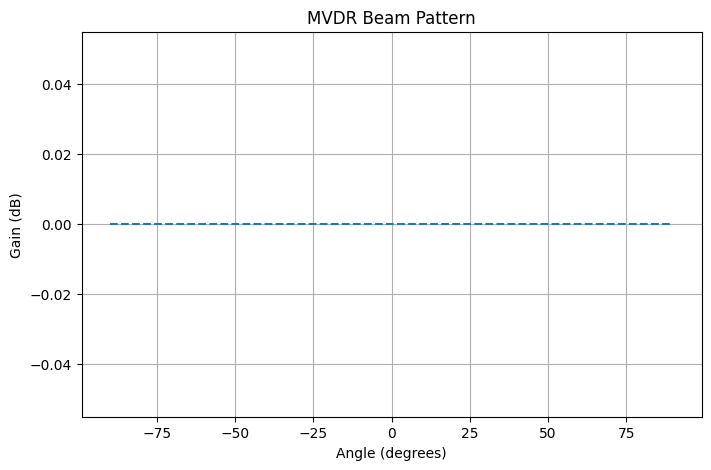

In [475]:

def closest_index(tensor, value):
  abs_diff = torch.abs(tensor - value)
  min_index = torch.argmin(abs_diff)
  return min_index

def get_power(steering_vector,stft_mics):
  """Apply MVDR beamforming in the frequency domain."""
  M, F, T = stft_mics.shape
  R = torch.einsum('mft,nft->fmn', stft_mics, stft_mics.conj()) / T  # Covariance matrix
  R_inv = torch.linalg.pinv(R)  # Inverse of covariance matrix
  power = 1/torch.einsum('fm,fmm,fm->f',steering_vector.conj(),R_inv,steering_vector)
  return power


# Plot Beam Pattern
theta_scan = torch.linspace(-90, 90, 180)  # Scan angles
beam_pattern = torch.zeros_like(theta_scan)

for i, theta in enumerate(theta_scan):
    delays_scan = compute_delays(theta, M, d, c)
    steering_scan = compute_steering_vector(delays_scan, freqs)
    power_resp = torch.abs(get_power(steering_scan,stft_mics))
    beam_pattern[i] = power_resp.mean()

plt.figure(figsize=(8, 5))
plt.plot(theta_scan, 20 * torch.log10(beam_pattern / beam_pattern.max()),linestyle='dashed')
plt.xlabel("Angle (degrees)")
plt.ylabel("Gain (dB)")
plt.title("MVDR Beam Pattern")
plt.grid()
plt.show()

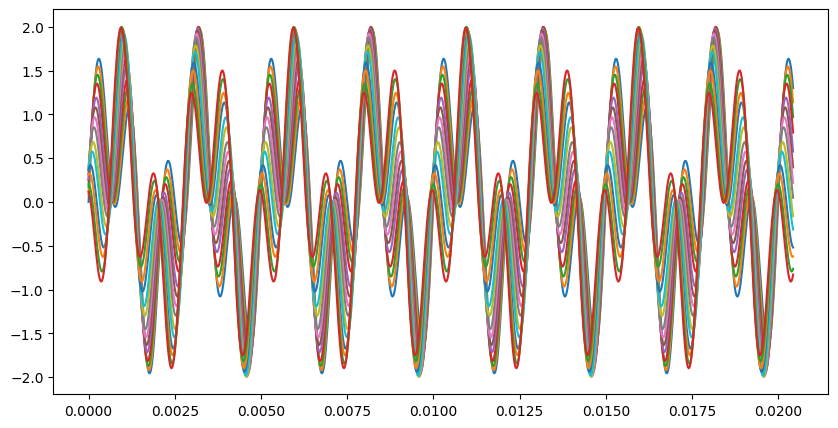

In [476]:
# Plot the mixed
f,ax = plt.subplots(figsize=(10, 5))
for m in range(M):
  ax.plot(t[:trange],mics[m,:trange])


# MVDR NarrowBand

In [974]:
# Lets implement a Narrowband MVDR... (First the basics)
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchaudio

# Simulation Parameters
c = 343.0  # Speed of sound in m/s
fs = 44000  # Sampling frequency (Hz)
d = 0.5  # Distance between microphones (m)
M = 16 # Number of microphones
T = 2.0  # Duration of signal (s)
n_samples = int(fs * T)
t = torch.arange(n_samples) / fs  # Time axis

In [975]:
def phase2delay(phase,freq):
    """Simple conversion from phase in rad to delay in time"""
    return phase/(2*np.pi*freq)



# Compute steering vector
def compute_steering_vector(delays, freq):
    """Compute steering vector for one freq (Outputs M)"""
    return torch.exp(-1j * 2 * torch.pi * freq * delays)

# MVDR beamformer weight
def mvdr_beamforming(target_steering_vector,mics):
    """Computes MVDR beamformer"""

    #Evaluate covariance
    N = mics.shape[-1]
    R = torch.einsum('MT,NT->MN',mics,mics.conj())/N
    Rinv = torch.linalg.pinv(R)

    # Evaluate filter
    w = torch.einsum('MM,M -> M',Rinv,target_steering_vector)/torch.einsum('M,MM,M->',target_steering_vector,Rinv,target_steering_vector.conj())
    
    return w

def apply_filter(w,mics,freq):
    # Extract phase and mag
    phase = torch.angle(w)
    mag = torch.abs(w)
    # Assume narrow band and apply the shifts and mag
    delay = phase2delay(phase,freq)
    # Apply the shift and add back up
    M,N= mics.shape
    y = torch.zeros(size=(N,))
    for m in range(M):
        shift = int(delay[m] * fs)
        y += mag[m]*torch.roll(mics[m,:], shift)
    return y

def beam_pattern(w,freq):
    theta_scan = torch.linspace(-90, 90, 180)  # Scan angles
    beam_pattern = torch.zeros_like(theta_scan)

    #Evaluate covariance
    N = mics.shape[-1]
    R = torch.einsum('MT,NT->MN',mics,mics.conj())/N
    Rinv = torch.linalg.pinv(R)

    for i, theta in enumerate(theta_scan):
        delays_scan = compute_delays(theta, M, d, c)
        steering_scan = compute_steering_vector(delays_scan, freq)
        power_resp = abs(torch.einsum('M,M->',w.conj(),steering_scan))
        beam_pattern[i] = power_resp

    return beam_pattern

    
    

In [976]:
# Source Signals
freq_target = 50  # Target signal frequency (Hz)
df = 5
freq_interf = freq_target+df  # Interference frequency (Hz)

target_signal = torch.sin(2 * torch.pi * freq_target * t)
interf_signal = torch.sin(2 * torch.pi * freq_interf * t)

# Angles of arrival (AoA)
theta_target = -82 # Target source angle (degrees)
theta_interf = -40  # Interfering source angle (degrees)

508 329
444 288
381 247
317 206
254 164
190 123
127 82
63 41
0 0
-63 -41
-127 -82
-190 -123
-254 -164
-317 -206
-381 -247
-444 -288
torch.Size([16, 88000])


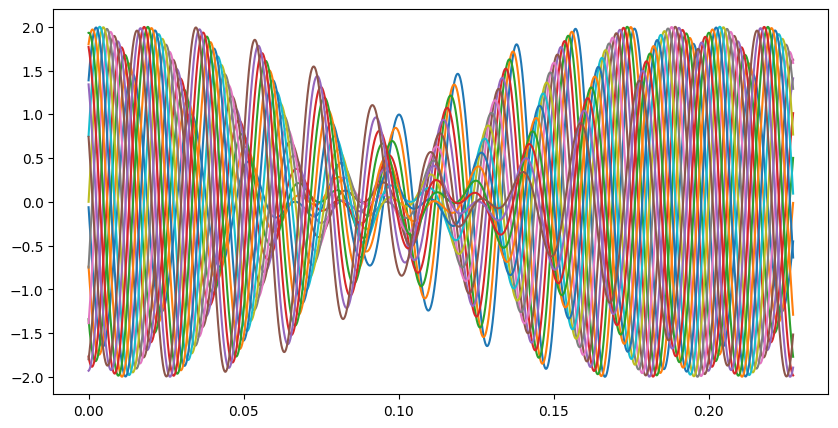

In [977]:
# Generate Sensor signal
# Compute delays
delays_target = compute_delays(theta_target, M, d, c)
delays_interf = compute_delays(theta_interf, M, d, c)

# Create multi-microphone signals
mvdr_mics = torch.zeros((M, n_samples))
int_mics = torch.zeros((M, n_samples))

for m in range(M):
    shift_t = int(delays_target[m] * fs) # shift in index
    shift_i = int(delays_interf[m] * fs)

    print(shift_t,shift_i)
    
    # Apply delays using roll (circular shift)
    mvdr_mics[m] += torch.roll(target_signal, shift_t)
    mvdr_mics[m] += torch.roll(interf_signal, shift_i)  # Interference weaker

    int_mics[m] += torch.roll(interf_signal, shift_i)

print(mvdr_mics.shape)
trange = 10000
f,ax = plt.subplots(figsize=(10, 5))
for m in range(M):
  ax.plot(t[:trange],mvdr_mics[m,:trange])


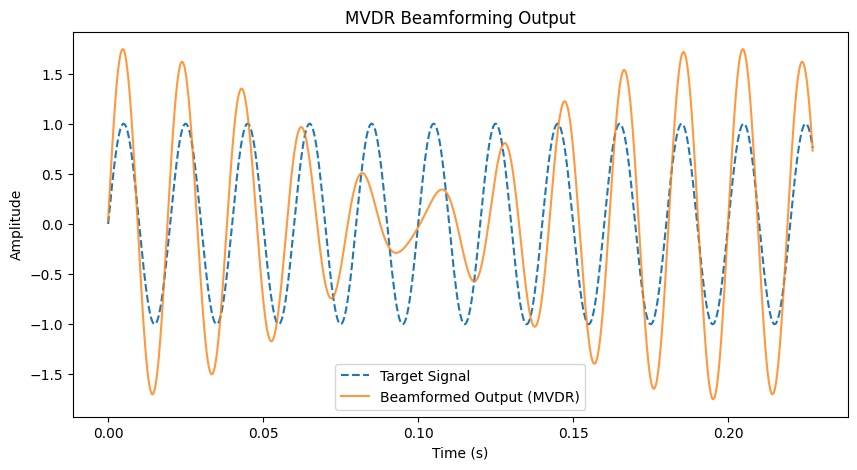

In [978]:
# Computer steering vector
target_steering_vector = compute_steering_vector(delays_target,freq_target)

# Evaluate MVDR
w = mvdr_beamforming(target_steering_vector,mvdr_mics)

# Forward pass 
y = apply_filter(w,mvdr_mics,freq_target)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t[:trange], target_signal[:trange], label="Target Signal", linestyle='dashed')
plt.plot(t[:trange], y[:trange], label="Beamformed Output (MVDR)", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("MVDR Beamforming Output")
plt.show()

50


/tmp/ipykernel_3342975/1577154437.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.deg2rad(torch.tensor(theta))


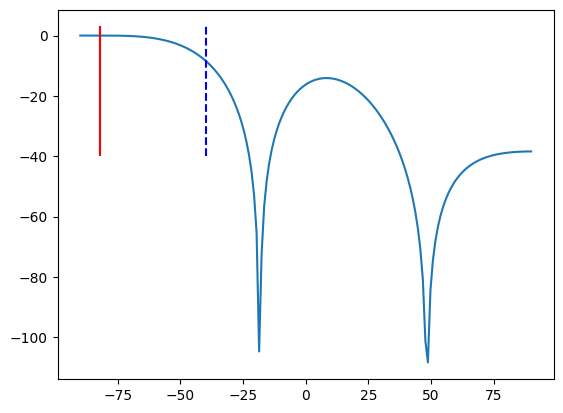

In [979]:
# Print beam pattern..
print(freq_target)
power = beam_pattern(w,freq_target)

plt.plot(torch.linspace(-90, 90, 180),20*torch.log(power))
plt.vlines(theta_target,ymin=-40,ymax=3,colors='r')
plt.vlines(theta_interf,ymin=-40,ymax=3,colors='b',linestyles='--')

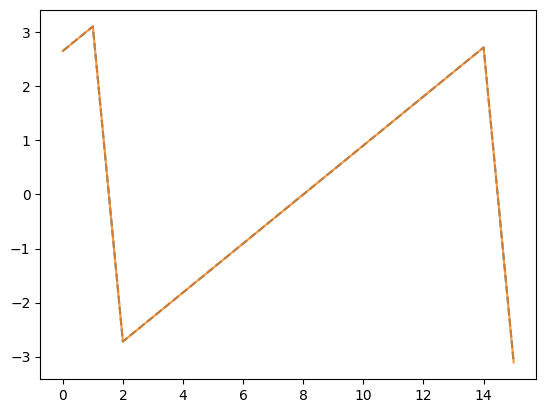

In [980]:
plt.plot(torch.angle(target_steering_vector),linestyle='--')
plt.plot(torch.angle(w),alpha=0.8)

# NarrowBand LCMV

In [1265]:
# Lets implement a Narrowband MVDR... (First the basics)
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchaudio

# Simulation Parameters
c = 343.0  # Speed of sound in m/s
fs = 44000  # Sampling frequency (Hz)
d = 0.5  # Distance between microphones (m)
M = 25  # Number of microphones
T = 2.0  # Duration of signal (s)
n_samples = int(fs * T)
t = torch.arange(n_samples) / fs  # Time axis

In [1266]:

def phase2delay(phase,freq):
    """Simple conversion from phase in rad to delay in time"""
    return phase/(2*np.pi*freq)

def compute_delays(theta, M, d, c):
    """Compute time delays for a given angle."""
    # Phase = omega * time_delay = 2*pi*f * time_delay
    theta_rad = torch.deg2rad(torch.tensor(theta))
    delays = (torch.arange(M)-M//2) * d * torch.sin(theta_rad) / c  # Delay per mic
    return delays

# Compute steering vector
def compute_steering_vector(delays, freq):
    """Compute steering vector for one freq (Outputs M)"""
    return torch.exp(-1j * 2 * torch.pi * freq * delays)

def lcmv_beamformer(C,g,mics):
    # C: Steering vectors (M,S) for Num of Microphones M and Number of sources S
    # g : gain vector (S,) binary
    #mics : Microphone readings (M,N) for number of snapshots N
    #Evaluate covariance
    N = mics.shape[-1]
    #R = torch.einsum('MT,NT->MN',mics,mics.conj())/N
    R = (mics @ mics.conj().T) / N
    Rinv = torch.linalg.pinv(R)#.to(torch.complex64)

    #Evaluate filter (C:MS,g:S,mics:MT)
    A = torch.einsum('MM,MS->MS',Rinv,C)
    B = torch.einsum('M,MM,M->',target_steering_vector,Rinv.to(torch.complex64),target_steering_vector.conj())#torch.linalg.pinv(torch.einsum('MS,MN,NK->SK',C,Rinv,C.conj()))
    w = torch.einsum('MK,KS,S -> M',A,torch.linalg.pinv(B),g.to(torch.complex64))#torch.einsum('MK,KS,S -> M',A,B,g.to(torch.complex64))
    #A = Rinv @ C  # (M, S)
    #B = torch.linalg.pinv(C.T.conj() @ Rinv @ C)  # (S, S)
    #w = A @ B @ g.to(torch.complex64) # (M,)

    return w


def beam_pattern(w,freq):
    theta_scan = torch.linspace(-90, 90, 180)  # Scan angles
    beam_pattern = torch.zeros_like(theta_scan)


    for i, theta in enumerate(theta_scan):
        delays_scan = compute_delays(theta, M, d, c)
        steering_scan = compute_steering_vector(delays_scan, freq)
        power_resp = abs(torch.einsum('M,M->',w.conj(),steering_scan))
        beam_pattern[i] = power_resp

    return beam_pattern

def apply_filter(w,mics,freq):
    # Extract phase and mag
    phase = torch.angle(w)
    mag = torch.abs(w)
    # Assume narrow band and apply the shifts and mag
    delay = phase2delay(phase,freq)
    # Apply the shift and add back up
    M,N= mics.shape
    y = torch.zeros(size=(N,))
    for m in range(M):
        shift = int(delay[m] * fs)
        y += mag[m]*torch.roll(mics[m,:], shift)
    return y

In [1267]:
# PART1 Signals & Gains
fc = 50

#Partition list
freqs = [fc,fc,fc,fc]
thetas = [-60,0,20,40]
target_idx = [1]
interf_idx = [2,3,0]

#Freq list
freqs_target = [freqs[i] for i in target_idx]  # Target signal frequency (Hz)
freqs_interf = [freqs[i] for i in interf_idx]  # Interference frequency (Hz)

#Thetas
thetas_target = [thetas[i] for i in target_idx]
thetas_interf = [thetas[i] for i in interf_idx]

#Gain vector
g_target = torch.ones(size=(len(freqs_target),))
g_interf = torch.zeros(size=(len(freqs_interf),))
g = torch.concat((g_target,g_interf))
print(g)

#Sources 
target_signals = [torch.sin(2 * torch.pi * f * t) for f in freqs_target]
interf_signals = [torch.sin(2 * torch.pi * f * t) for f in freqs_interf]

tensor([1., 0., 0., 0.])


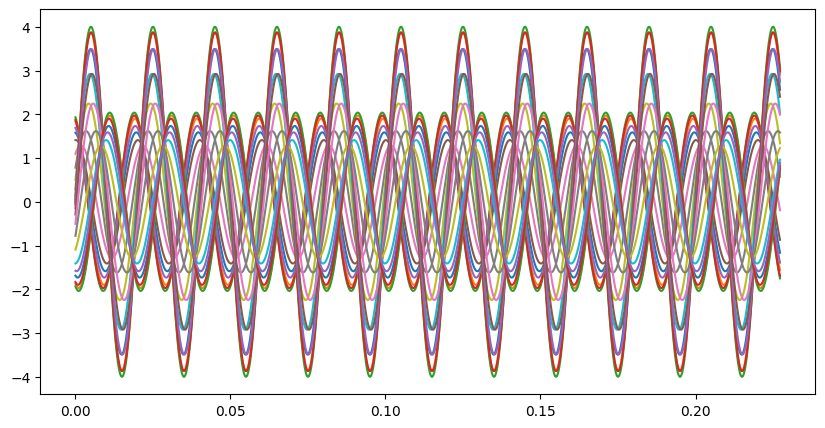

In [1268]:
# PART2 Record The Signals

# Compute Delay
target_delays = [compute_delays(theta, M, d, c) for theta in thetas_target]
interf_delays = [compute_delays(theta, M, d, c) for theta in thetas_interf]

# Microphones
lcmv_mics = torch.zeros((M, n_samples))

for m in range(M):
    # Part 1 : Add targets first
    for i in range(len(target_delays)):
      shift = int(target_delays[i][m] * fs)
      lcmv_mics[m] += torch.roll(target_signals[i], shift)

    # Part 2 : Add interferences first
    for i in range(len(interf_delays)):
      shift = int(interf_delays[i][m] * fs)
      lcmv_mics[m] += torch.roll(interf_signals[i], shift)


trange = 10000
f,ax = plt.subplots(figsize=(10, 5))
for m in range(M):
  ax.plot(t[:trange],lcmv_mics[m,:trange])


In [1269]:
# Evaluate stacked steering vectors (M,Ns)
C = [torch.Tensor(compute_steering_vector(delay, f)) for delay,f in zip(target_delays+interf_delays,freqs_target+freqs_interf)]
C = torch.stack(C,dim=-1)
# Evaluate LCMV
w = lcmv_beamformer(C,g,lcmv_mics)

# BeamPattern LCMV
power = beam_pattern(w,fc)
plt.hlines(0,xmin=-90,xmax=90,colors='g',linestyles='--')
plt.plot(torch.linspace(-90, 90, 180),10*torch.log(power))
for theta_target in thetas_target:
  plt.vlines(theta_target,ymin=-80,ymax=10,colors='r')

for theta_interf in thetas_interf:
  plt.vlines(theta_interf,ymin=-80,ymax=10,colors='b',linestyles='--')

RuntimeError: einsum(): subscript M has size 25 for operand 1 which does not broadcast with previously seen size 16

In [1270]:
# Apply Beamformer
y = apply_filter(w,lcmv_mics,fc)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t[:trange], sum(target_signals)[:trange], label="Target Signal", linestyle='dashed')
plt.plot(t[:trange], y[:trange], label="Beamformed Output (LCMV)", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("LCMV Beamforming Output")
plt.show()



IndexError: index 16 is out of bounds for dimension 0 with size 16

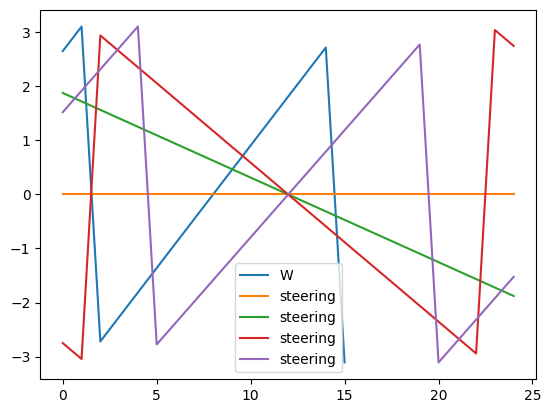

In [1271]:
plt.plot(torch.angle(w),label='W')
plt.plot(torch.angle(C),label='steering')
plt.legend()

# TRoubleshoot

In [1272]:
N = lcmv_mics.shape[-1]
Rinv_lcmv = torch.linalg.pinv(lcmv_mics @ lcmv_mics.T.conj()/N)
Rinv_mvdr = torch.linalg.pinv(mvdr_mics @ mvdr_mics.T.conj()/N)
#w = torch.einsum('MM,M -> M',Rinv,target_steering_vector)/torch.einsum('M,MM,M->',target_steering_vector,Rinv,target_steering_vector.conj())

A1 = torch.einsum('MN,N -> M',Rinv_mvdr.to(torch.complex64) ,target_steering_vector)
A2 = Rinv_lcmv.to(torch.complex64) @ C

#A3 = torch.einsum('MN,N -> M',Rinv_lcmv.to(torch.complex64),target_steering_vector)#(Rinv_mvdr.to(torch.complex64) @ target_steering_vector)
print(A1.shape,A2.shape)


torch.Size([16]) torch.Size([25, 4])


In [1273]:
B1 = torch.einsum('M,MN,N->',target_steering_vector.conj(),Rinv_mvdr.to(torch.complex64),target_steering_vector)
B2 = torch.einsum('NS,NM,MK->SK',C.conj(),Rinv_lcmv.to(torch.complex64),C)

print(B1,B2)

tensor(4.0258-4.7684e-07j) tensor([[0.1499+0.0000e+00j, 0.1560+1.7644e-07j, 0.1408+9.9274e-08j,
         0.0999+1.9695e-08j],
        [0.1560+6.3330e-08j, 0.8604+1.3745e-07j, 0.4736-1.6883e-08j,
         0.2614-2.0433e-07j],
        [0.1408+4.4703e-08j, 0.4736-4.6016e-08j, 0.2854-3.7096e-08j,
         0.1676-1.5103e-07j],
        [0.0999+1.4901e-08j, 0.2614-2.3812e-08j, 0.1676-1.9442e-08j,
         0.1021-5.6818e-08j]])


In [1274]:
w_lcmv_1 = torch.einsum('MS,SK,K -> M',A2,torch.linalg.pinv(B2),g.to(torch.complex64))
w_lcmv = A2 @ torch.linalg.pinv(B2) @ g.to(torch.complex64)
w_mvdr = (A1/B1).squeeze()

print(w_lcmv)
print(w_lcmv_1)
print(w_mvdr)
print(g.to(torch.complex64))

tensor([-0.0050-6.4856e-02j, -0.0130-7.5524e-02j, -0.0174-7.9430e-02j,
        -0.0168-7.6878e-02j, -0.0103-6.9516e-02j,  0.0016-5.7989e-02j,
         0.0181-4.5033e-02j,  0.0377-3.2041e-02j,  0.0583-2.0705e-02j,
         0.0775-1.1958e-02j,  0.0930-5.8706e-03j,  0.1031-2.2741e-03j,
         0.1066+2.3576e-08j,  0.1031+2.2742e-03j,  0.0930+5.8707e-03j,
         0.0775+1.1958e-02j,  0.0583+2.0705e-02j,  0.0377+3.2041e-02j,
         0.0181+4.5033e-02j,  0.0016+5.7989e-02j, -0.0103+6.9516e-02j,
        -0.0168+7.6878e-02j, -0.0174+7.9430e-02j, -0.0130+7.5523e-02j,
        -0.0050+6.4856e-02j])
tensor([-0.0050-6.4856e-02j, -0.0130-7.5524e-02j, -0.0174-7.9430e-02j,
        -0.0168-7.6878e-02j, -0.0103-6.9516e-02j,  0.0016-5.7989e-02j,
         0.0181-4.5033e-02j,  0.0377-3.2041e-02j,  0.0583-2.0705e-02j,
         0.0775-1.1958e-02j,  0.0930-5.8706e-03j,  0.1031-2.2741e-03j,
         0.1066+2.3576e-08j,  0.1031+2.2742e-03j,  0.0930+5.8707e-03j,
         0.0775+1.1958e-02j,  0.0583+2.0705e-02

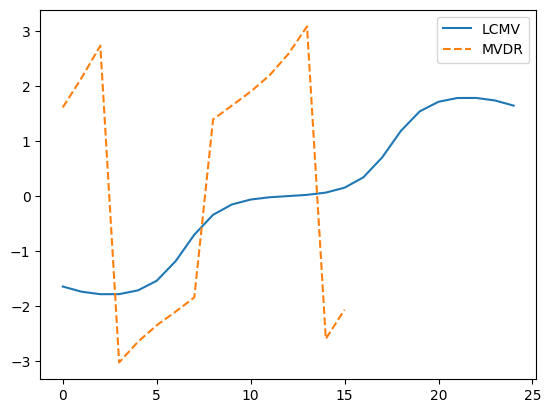

In [1275]:
plt.plot(torch.angle(w_lcmv),label='LCMV')
plt.plot(torch.angle(w_mvdr),label='MVDR',linestyle='--')
plt.legend()

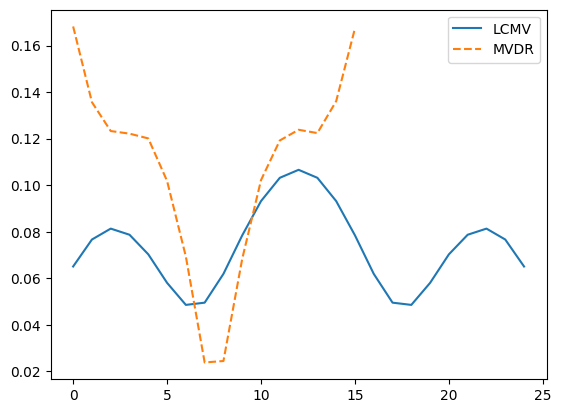

In [1276]:
plt.plot(torch.abs(w_lcmv),label='LCMV')
plt.plot(torch.abs(w_mvdr),label='MVDR',linestyle='--')
plt.legend()

In [1277]:
# Print beam pattern..
power_mvdr = beam_pattern(w_mvdr,fc)
power_lcmv = beam_pattern(w_lcmv_1,fc)

plt.plot(torch.linspace(-90, 90, 180),20*torch.log(power_mvdr),label="Beampattern (MVDR)", alpha=0.8)
plt.plot(torch.linspace(-90, 90, 180),20*torch.log(power_lcmv),label="Beampattern (LCMV)", alpha=0.8,linestyle='--')
plt.legend()

for theta in thetas_target:
  plt.vlines(theta,ymin=-40,ymax=3,colors='r')

for theta in thetas_interf:
  plt.vlines(theta,ymin=-40,ymax=3,colors='b',linestyles='--')
  
plt.hlines(0,-90,90,color='g',linestyles='--')

/tmp/ipykernel_3342975/1577154437.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_rad = torch.deg2rad(torch.tensor(theta))


RuntimeError: einsum(): subscript M has size 25 for operand 1 which does not broadcast with previously seen size 16

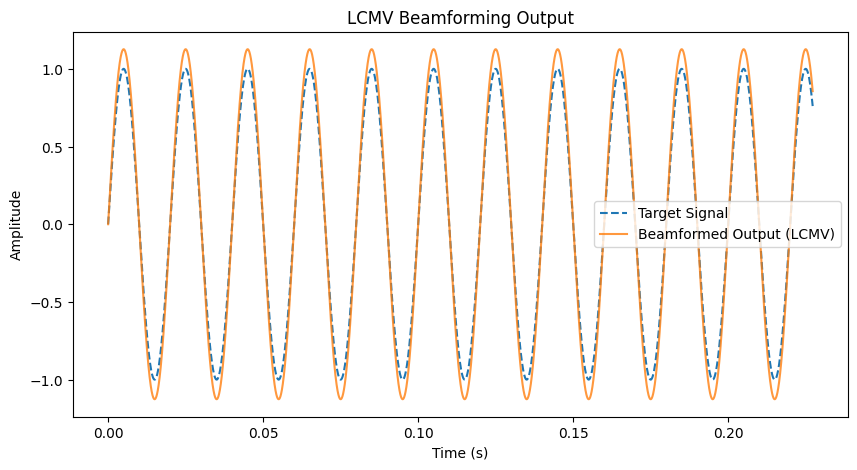

In [1278]:
# Apply Beamformer
y_lcmv= apply_filter(w_lcmv,lcmv_mics,fc)
y_mvdr= apply_filter(w_mvdr,mvdr_mics,fc)


# Plot
plt.figure(figsize=(10, 5))
plt.plot(t[:trange], sum(target_signals)[:trange], label="Target Signal", linestyle='dashed')
#plt.plot(t[:trange], sum(interf_signals)[:trange], label="Interf Signal", linestyle='dashed')
plt.plot(t[:trange], y_lcmv[:trange], label="Beamformed Output (LCMV)", alpha=0.8)
#plt.plot(t[:trange], y_mvdr[:trange], label="Beamformed Output (MVDR)", alpha=0.8,linestyle=':')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("LCMV Beamforming Output")
plt.show()



# GSC NarrowBa